In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import urllib #For webscraping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearnex import patch_sklearn #intel patch that supposedly improves performance on intel processors


# set plot style
sns.set()

In [2]:
# Read data in and view first few entries
df = pd.read_csv('train_set.csv')
df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
df.iloc[0]['text']

'umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrika'

Behold, the most perfectly balanced dataset:

In [8]:
lang_counts = df["lang_id"].value_counts()
lang_counts.name = "Count"
percs = df["lang_id"].value_counts(normalize=True) #turns out this normalize parameter converts to %
percs.name = "Percentage"

pd.concat([lang_counts, percs], axis=1)

,Count,Percentage
xho,3000,0.090909
eng,3000,0.090909
nso,3000,0.090909
ven,3000,0.090909
tsn,3000,0.090909
nbl,3000,0.090909
zul,3000,0.090909
ssw,3000,0.090909
tso,3000,0.090909
sot,3000,0.090909


## Data Engineering

---
First things first, some pre-processing. Since this is language identification, I will not be removing stop words because stop words might be important in distinguishing between languages. Additionally, I doubt NTLK contains stopwords for all 11 Ofiicial South African languages. What I will be doing is removing all punctuation, standardizing text to remove any non-standard characters and converting all capital letters to lowercase

In [9]:
df['text'] = df['text'].str.lower()

In [10]:
normal_chars = 'abcdefghijklmnopqrstuvwxyz0123456789 '

In [11]:
def remove_weird_chars(post):
    return ''.join([l for l in post if l in normal_chars])

In [12]:
df['text'] = df['text'].apply(remove_weird_chars)
df['text'].iloc[0]

'umgaqosiseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrika'

Time to create features and label dataset

In [13]:
X = df["text"]
y = df["lang_id"]

Once data engineering is done, the next step is to do a train-test split. This must be done before any model training so that a portion of the data remains unseen by the model. This unseen test data can then be reliably used to determine the model's performance after training

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Using SKlearns TF-IDF vectorizer. It is a bag-of-words approach which counts the occurances of words in the corpus for each document. The twist here is that instead of tokenizing on words, I am tokenizing using characters, with character ngrams having a length of between 4 and 6. Tokenizing based on characters has has resulted in improved F1 scores for the model I have trained. It does however drastically increase the time required for vectorization and model training due to the sheer number of ngrams produced. 

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

Fitting and transforming the vector using the training dataset. This takes a while, and creates a sparse matrix with over 300 000 columns! Thankfully sparse matrices are more memory-efficient that ndarrays. 

In [16]:
vect = TfidfVectorizer(min_df=5, max_df=0.1, analyzer='char', ngram_range=(4,6), stop_words=None)
vect.fit_transform(X_train)

<24750x316517 sparse matrix of type '<class 'numpy.float64'>'
	with 13914086 stored elements in Compressed Sparse Row format>

Simple Grid search to determine what the best alpha parameter is for the Complement Naive Bayes model I'll be training. Only one parameter, alpha which is the smoothing parameter. I chose complememt Naive Bayes over standard multinomial Naive Bayes because it produced better results in our predict project and according to the sklearn documentation it generally produces better performing models, at least according to the inventers of the model: 

--Rennie, J. D., Shih, L., Teevan, J., & Karger, D. R. (2003). Tackling the poor assumptions of naive bayes text classifiers. In ICML (Vol. 3, pp. 616-623).

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
from sklearn.naive_bayes import ComplementNB

In [19]:
param_grid = {'alpha': [0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2,3,4,5,6,7,8,9,10]}

In [20]:
grid_CNB = GridSearchCV(ComplementNB(), param_grid, scoring='neg_log_loss')

This cell takes a minute or two to run..

In [21]:
grid_CNB.fit(vect.transform(X_train), y_train)
grid_CNB.best_params_

{'alpha': 0.1}

Best value for the alpha parameter is 0.1, not 1 which is the default value. Training model now..

In [24]:
nb = ComplementNB(alpha=0.1)

this patch_learn module is provided by intel and it supposedly improves the performance of the Sklearn module on computers with intel processors. Haven't noticed a speed-up but it produces the same model regardless.

In [23]:
patch_sklearn()
nb.fit(vect.transform(X_train), y_train)
y_pred = nb.predict(vect.transform(X_test))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


As shwon by the F-1 scores for each class and the weighted average F-1 score. Our model had performed very well. All precision and recall metrics are similarly either very close to 1 or 1 exactly. We can conclude from this that our model has no difficult indentifying any of the 11 classes

In [25]:
print(metrics.classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

         afr    0.99735   1.00000   0.99868       754
         eng    0.99478   1.00000   0.99738       762
         nbl    1.00000   0.99864   0.99932       734
         nso    1.00000   0.99872   0.99936       782
         sot    0.99868   1.00000   0.99934       759
         ssw    1.00000   0.99863   0.99932       732
         tsn    1.00000   0.99598   0.99799       746
         tso    1.00000   1.00000   1.00000       700
         ven    1.00000   1.00000   1.00000       785
         xho    1.00000   1.00000   1.00000       761
         zul    1.00000   0.99864   0.99932       735

    accuracy                        0.99915      8250
   macro avg    0.99917   0.99915   0.99915      8250
weighted avg    0.99915   0.99915   0.99915      8250



In [26]:
cm = confusion_matrix(y_test, y_pred)

In [27]:
labels = df['lang_id'].unique()
labels = list(labels)
labels.sort()
#labels = []
print(labels)

['afr', 'eng', 'nbl', 'nso', 'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']


In [28]:
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=labels, columns=labels)
cm

,afr,eng,nbl,nso,sot,ssw,tsn,tso,ven,xho,zul
afr,754,0,0,0,0,0,0,0,0,0,0
eng,0,762,0,0,0,0,0,0,0,0,0
nbl,1,0,733,0,0,0,0,0,0,0,0
nso,0,0,0,781,1,0,0,0,0,0,0
sot,0,0,0,0,759,0,0,0,0,0,0
ssw,0,1,0,0,0,731,0,0,0,0,0
tsn,1,2,0,0,0,0,743,0,0,0,0
tso,0,0,0,0,0,0,0,700,0,0,0
ven,0,0,0,0,0,0,0,0,785,0,0
xho,0,0,0,0,0,0,0,0,0,761,0


In [149]:
cm = cm.to_numpy()
cm_perc = cm/cm.sum(axis=1).reshape(-1, 1)

There are only 6 documents in the test dataset that are incorrectly labeled by the model:

Text(0.5, 1.0, 'Confusion Matrix')

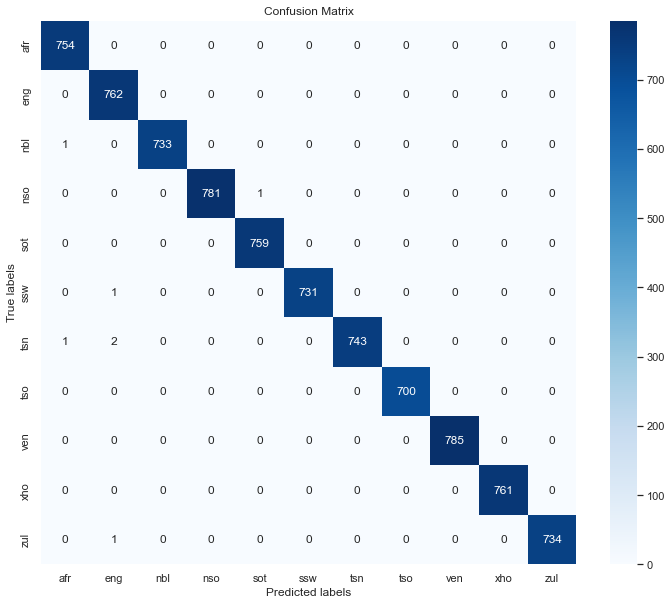

In [150]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.title("Confusion Matrix")
# plt.set_xticklabels(labels)
#plt.savefig('Confusion matrix.png', format='png', dpi=300, bbox_inches='tight')

Loading Kaggle dataset, doing pre-processing and making a csv file

In [151]:
# Read data in and view first few entries
df_test = pd.read_csv('test_set.csv')
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [152]:
df_test['text'] = df_test['text'].str.lower()

In [153]:
df_test['text'] = df_test['text'].apply(remove_weird_chars)
df_test['text'].iloc[0]

'mmasepala fa maemo a a kgethegileng a letlelela kgato eo'

In [154]:
X_Kaggle = df_test['text']

In [155]:
X_Kaggle.shape

(5682,)

In [156]:
kaggle_pred = nb.predict(vect.transform(X_Kaggle))

In [157]:
kaggle_pred

array(['tsn', 'nbl', 'ven', ..., 'sot', 'sot', 'nbl'], dtype='<U3')

In [158]:
pred_df = pd.DataFrame(data=df_test['index'], columns=['index'])

pred_df.insert(1, 'lang_id', kaggle_pred, allow_duplicates=False)
pred_df = pred_df.set_index('index')
pred_df.head()

,lang_id
index,
1,tsn
2,nbl
3,ven
4,ssw
5,afr


In [141]:
pred_df.to_csv(path_or_buf='MNB_alpha0.1_TFIDFcharngrams4,6mindf5maxdf0.1.csv', index=True)